### Look at the offshore extent of the Mackenzie River and its time series/drivers

In [57]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
import os
from itertools import compress
import datetime as dt
from datetime import date
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from math import sin, cos, sqrt, atan2, radians
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

##### Parameters:

In [3]:
# Domain dimensions:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

# Results folders:
folder_ref = '/data/brogalla/run_storage/Mn-set4-202004/'
folder_riv = '/data/brogalla/run_storage/riv-2a-202005/'
folder_con = '/data/brogalla/run_storage/riv-2b-202005/'

# Color map:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(164/N, 1, N)
vals_cont[:, 1] = np.linspace(116/N, 1, N)
vals_cont[:, 2] = np.linspace(84/N, 1, N)
cont_cmap = ListedColormap(vals_cont).reversed()

vals_glac = np.ones((N, 4))
vals_glac[:, 0] = np.linspace(113/N, 1, N)
vals_glac[:, 1] = np.linspace(169/N, 1, N)
vals_glac[:, 2] = np.linspace(144/N, 1, N)
glac_cmap = ListedColormap(vals_glac).reversed()

vals_both = np.ones((N, 4))
vals_both[:, 0] = np.linspace(89/N, 1, N); 
vals_both[:, 1] = np.linspace(89/N, 1, N)
vals_both[:, 2] = np.linspace(89/N, 1, N)
both_cmap = ListedColormap(vals_both).reversed()

##### Load files:

In [4]:
# Meshmasks
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])
land_mask = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]

mesh  = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
lon   = np.array(mesh.variables['nav_lon'])
lat   = np.array(mesh.variables['nav_lat'])

In [5]:
ref   = nc.Dataset('/data/brogalla/run_storage/Mn-set4-202004/ref-2002/ANHA12_EXH006_2002_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

##### Functions:

In [6]:
def load_monthly_results(year): # consider switching to five-day later
    
    file = 'ANHA12_EXH006_'+str(year)+'_monthly.nc'
    
    base_monthly = nc.Dataset(folder_ref+'ref-'+str(year)+'/'+file); 
    glac_monthly = nc.Dataset(folder_riv+'riv-2a-'+str(year)+'/'+file); 
    cont_monthly = nc.Dataset(folder_con+'riv-2b-'+str(year)+'/'+file);
    
    dmn_base = np.array(base_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_glac = np.array(glac_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_cont = np.array(cont_monthly.variables['dissolmn'])[:,0,:,:,:]
    
    return dmn_base, dmn_glac, dmn_cont

Calculate the proportional contribution of glacial rivers to each grid cell:

$$ prop = \frac{Mn_{glacier}-Mn_{base}}{Mn_{base}} = \frac{Mn_{glacier}}{Mn_{base}} - 1 $$

In [7]:
def calculate_prop(dmn_riv_off, dmn_riv_on):
    # Input arguments:
    # - dmn_riv_on (t,z,y,x) --- concentration of dMn with riverine contribution on
    # - dmn_riv_off(t,z,y,x) --- concentration of dMn with rivers off
    
    diff_rivers = dmn_riv_on - dmn_riv_off
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    prop_river  = np.divide(diff_rivers, dmn_riv_off)
    
    # Output:
    # - prop_river(t,z,y,x)  --- proportional contribution of river to observed [dMn]
    return prop_river

In [8]:
def calc_distance(i,j):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats[i,j]]
    lons_rad = [radians(l) for l in lons[i,j]]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

In [44]:
def file_dates(year):
    #start_date and end_date are datetime objects
    start_date = dt.datetime(year,1,1)
    end_date   = dt.datetime(year,12,31)
    
    file_list1 = np.sort(os.listdir(results_folder+'ref-'+str(year)+'/'))
    file_list2 = np.sort(os.listdir('/data/brogalla/ANHA12/'))
    
    Vlist = [i[26:31]=='gridV' for i in file_list2]
    gridV_list = list(compress(file_list2, Vlist))
    dateV_list = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_list]
    gridV_file_list = list(compress(gridV_list, [V > start_date and V < end_date for V in dateV_list]))
    
    dates = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_file_list]
    
    return dates

##### Calculations:

In [ ]:
dates_2002 = file_dates(2002); dates_2003 = file_dates(2003); dates_2004 = file_dates(2004);
dates_2005 = file_dates(2005); dates_2006 = file_dates(2006); dates_2007 = file_dates(2007);
dates_2008 = file_dates(2008); dates_2009 = file_dates(2009); dates_2010 = file_dates(2010);
dates_2011 = file_dates(2011); dates_2012 = file_dates(2012); dates_2013 = file_dates(2013);
dates_2014 = file_dates(2014); dates_2015 = file_dates(2015); dates_2016 = file_dates(2016);
dates_2017 = file_dates(2017) ;dates_2018 = file_dates(2018); dates_2019 = file_dates(2019);

dates = np.array(dates_2002 + dates_2003 + dates_2004 + dates_2005 + dates_2006 + dates_2007 + dates_2008 + \
                 dates_2009 + dates_2010 + dates_2011 + dates_2012+ dates_2013 + dates_2014 + dates_2015 + \
                 dates_2016 + dates_2017 + dates_2018 + dates_2019)

In [41]:
mack_li = 670; mack_lj = 340;
mack_ri = 630; mack_rj = 300;

In [51]:
year1 = 2002
year2 = 2019
    
ts_cont_lmack = []
ts_cont_rmack = []
for year in range(year1, year2+1):
    dmn_base, dmn_glac, dmn_cont = load_monthly_results(year)
        
    # average over the top 10 grid cells:
    prop_lmack = calculate_prop(dmn_base[:,0:10,mack_li,mack_lj], dmn_cont[:,0:10,mack_li,mack_lj])
    prop_rmack = calculate_prop(dmn_base[:,0:10,mack_ri,mack_rj], dmn_cont[:,0:10,mack_ri,mack_rj])
    prop_lmack_top = np.nanmean(prop_lmack, axis=1)*100
    prop_rmack_top = np.nanmean(prop_rmack, axis=1)*100
    
    ts_cont_lmack.append(prop_lmack_top.flatten())
    ts_cont_rmack.append(prop_rmack_top.flatten())

    
ts_lmack = np.array(ts_cont_lmack).flatten()
ts_rmack = np.array(ts_cont_rmack).flatten()

In [54]:
date_list = np.array([dt.datetime(year,1,1) for year in range(2002,2020)])

date_list = []
for year in range(2002,2020):
    for month in range(1,13):
        date_list.append(dt.datetime(year,month,1))

##### Figures

No handles with labels found to put in legend.


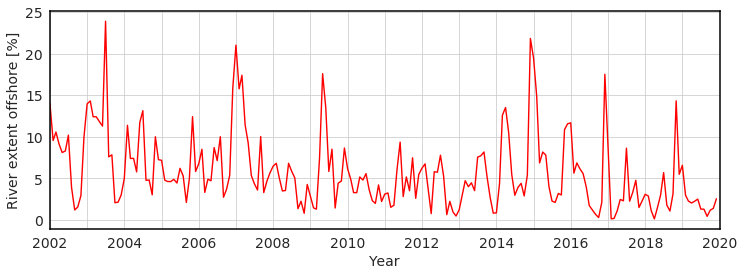

In [75]:
fig = plt.figure(figsize=(12,4))
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(date_list, ts_rmack, linewidth=1.4, color='r')
    
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('River extent offshore [%]',fontsize=14)
    ax.set_xticks([dt.datetime(year,1,1) for year in range(2002, 2022)])
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)))
    ax.set_xticklabels([2002,"",2004,"",2006,"",2008,"",2010,"",2012,"",2014,"",2016,"",2018,"",2020])
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    leg = ax.legend(loc=(0.03, 0.84), frameon=True, framealpha=0.7, fontsize=13)
    leg.get_frame().set_linewidth(0.0)
    

No handles with labels found to put in legend.


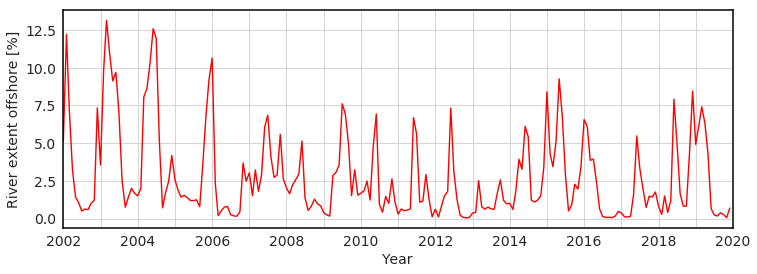

In [76]:
fig = plt.figure(figsize=(12,4))
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(date_list, ts_lmack, linewidth=1.4, color='r')
    
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('River extent offshore [%]',fontsize=14)
    ax.set_xticks([dt.datetime(year,1,1) for year in range(2002, 2022)])
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)))
    ax.set_xticklabels([2002,"",2004,"",2006,"",2008,"",2010,"",2012,"",2014,"",2016,"",2018,"",2020])
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    leg = ax.legend(loc=(0.03, 0.84), frameon=True, framealpha=0.7, fontsize=13)
    leg.get_frame().set_linewidth(0.0)
    

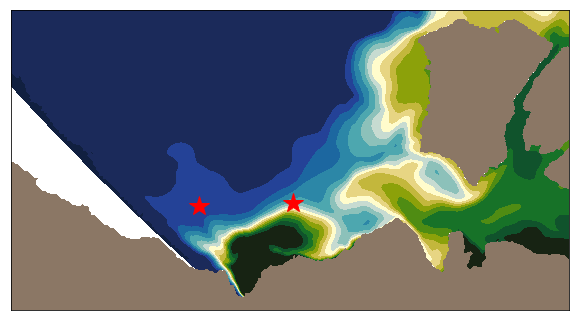

In [39]:
fig, ax1 = plt.subplots(figsize=(10,12))


proj2 = Basemap(projection='stere',lat_0 = 72, lon_0 = -135, resolution='i', width=1.3e6, height=0.7e6, ax=ax1)

x_land, y_land = proj2(lon, lat)
proj2.contourf(x_land[:,:], y_land[:,:], land_mask[10,:,:], \
               cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)


x_model, y_model = proj2(lons, lats)
proj2.plot(x_model[630, 300], y_model[630, 300], '*r', markersize=20)
proj2.plot(x_model[670, 340], y_model[670, 340], '*r', markersize=20)


# Coloured contours:
CS1 = proj2.contourf(x_model, y_model, prop_cont[0,:,:]*100, \
                     levels=np.arange(0,15,1), vmin=0, vmax=15, cmap=cmocean.cm.delta, extend='both')

# # # Contour lines:
# # vmin_cglac=-4;
# # contour_glac = 2; cvmax_glac = 4;
# # glac = proj2.contour(x_model, y_model, diff_glacier[month], \
# #                      levels=np.arange(vmin_cglac, cvmax_glac+contour_glac, contour_glac), \
# #                      vmin=vmin_cglac, vmax=vmax_glac, colors='w')

# # Colorbars:
# cbaxes2 = fig.add_axes([0.99, 0.23, 0.04, 0.34])  
# CBar1   = plt.colorbar(CS1, ax=ax1, cax=cbaxes2, ticks=np.arange(-16,16,1), drawedges=True) 
# CBar1.ax.tick_params(axis='y', length=0, labelsize=14)

# # fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R2-CAA.png', bbox_inches='tight', dpi=300)